In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
from keras import layers, Sequential
from keras.applications import ResNet50, ResNet50V2, ResNet101V2, Xception
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam

In [3]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = "../Dog_Breed_Dataset/Dog_60subset/"
model_name = 'model_1_resnet100_classifier_fulldata'
model_path = './output/models/'

epochs = 60

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names


Found 39276 files belonging to 60 classes.
Using 31421 files for training.
Found 39276 files belonging to 60 classes.
Using 7855 files for validation.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [6]:
num_classes = len(class_names) 

# Load the pre-trained ResNet50 model (without the top layer)
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50V2(weights='imagenet',include_top=False, input_shape=(img_height, img_width, 3))
# base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3), classes=num_classes)
# Freeze the layers of the pre-trained model
base_model.trainable = False

# build the entire model
x = base_model.output
x = tf.keras.applications.xception.preprocess_input(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# global average pooling and dense layers
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
# model.summary()

83683744/83683744 [==============================] - 4s 0us/step


In [7]:
early_stopping = EarlyStopping(monitor="val_sparse_top_k_categorical_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_sparse_top_k_categorical_accuracy", factor=0.1, patience=4, min_lr=0.000001)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy, tf.keras.metrics.sparse_top_k_categorical_accuracy])

model_history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1, batch_size=batch_size,
                          callbacks=[early_stopping, reduce_lr])

Epoch 1/60
982/982 [==============================] - 218s 170ms/step - loss: 3.5838 - categorical_accuracy: 1.2730e-04 - top_k_categorical_accuracy: 0.0071 - val_loss: 3.4581 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/60
982/982 [==============================] - 198s 202ms/step - loss: 3.4673 - categorical_accuracy: 0.0000e+00 - top_k_categorical_accuracy: 0.0023 - val_loss: 3.4273 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/60
982/982 [==============================] - 177s 180ms/step - loss: 3.4258 - categorical_accuracy: 0.0000e+00 - top_k_categorical_accuracy: 9.2295e-04 - val_loss: 3.3779 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/60
982/982 [==============================] - 173s 176ms/step - loss: 3.4009 - categorical_accuracy: 0.0000e+00 - top_k_categorical_accuracy: 0.0015 - val_lo

KeyboardInterrupt: 

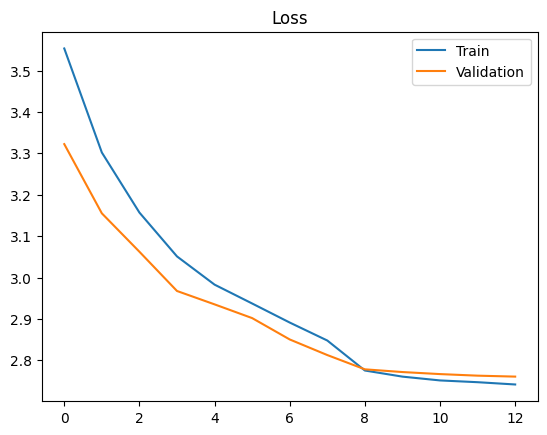

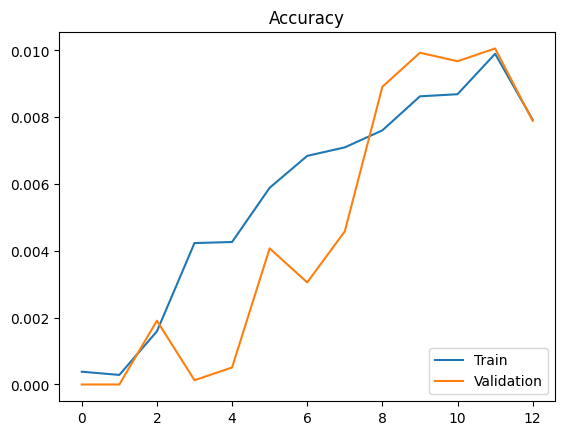

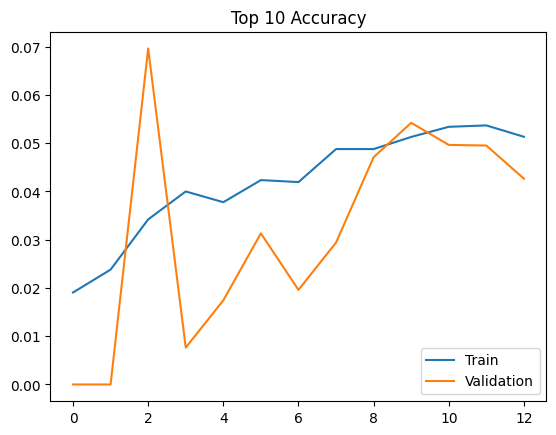

In [21]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

acc_train_curve = model_history.history["categorical_accuracy"]
acc_val_curve = model_history.history["val_categorical_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

top5_acc_train_curve = model_history.history["top_k_categorical_accuracy"]
top5_acc_val_curve = model_history.history["val_top_k_categorical_accuracy"]
plt.plot(top5_acc_train_curve, label = "Train")
plt.plot(top5_acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Top 10 Accuracy") 
plt.show()

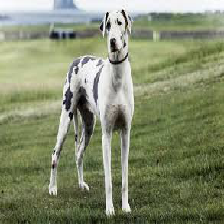

In [22]:
#Testing
img = tf.keras.preprocessing.image.load_img(path="../Dog_Breed_Dataset/Dog_60subset/Great_Dane/n112004.jpg", target_size=(img_width,img_height))
img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)
img_array = np.array([img_array]) 
# img_array = np.expand_dims(img_array, axis=0)
img

In [23]:
# generate predictions for samples
predictions = model.predict(img_array)

# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)

# get top 10 predictions
top_10_predictions = np.argsort(predictions[0])[:-11:-1]

# top 10 predictions
for i in range(len(top_10_predictions)):
    print("Dog ID:", class_names[top_10_predictions[i]])

1/1 [==============================] - 1s 1s/step
Dog ID: golden_retriever
Dog ID: Cardigan
Dog ID: Afghan_hound
Dog ID: chinese_rural_dog
Dog ID: Bedlington_terrier
Dog ID: African_hunting_dog
Dog ID: cairn
Dog ID: dingo
Dog ID: briard
Dog ID: basenji


In [14]:
# save model and architecture to single file
model.save(model_path + model_name + '.h5')
print(model_path + model_name + '.h5', "Saved model to disk")

./output/models/model_1_resnet100_classifier_fulldata.h5 Saved model to disk
